# Deep Learning Project 1: DeepPaint

This section defines the necessary classes to handle the dataset (download, uncompress, split, etc.)

In [ ]:
from PIL import Image, ImageCms
import os, os.path
import torch
from enum import Enum
import numpy as np
from skimage.color import rgb2lab, rgb2gray, lab2rgb, xyz2rgb
from torchvision import datasets, transforms
import torchvision.models as models
import random
from sklearn.model_selection import train_test_split
import glob

class GrayscaleImageFolder(datasets.ImageFolder):
  '''Custom images folder, which converts images to grayscale before loading'''
  def __getitem__(self, index):
    path, target = self.imgs[index]
    img = self.loader(path)
    img_l = None
    img_ab = None
    if self.transform is not None:
      img_original = self.transform(img)
      img_original = np.asarray(img_original)
      img_lab = rgb2lab(img_original)
      img_lab = (img_lab + 128) / 255
      img_ab = img_lab[:, :, 1:3]
      img_ab = torch.from_numpy(img_ab.transpose((2, 0, 1))).float()
      img_l = img_lab[:, :, 0:1]
      img_l = torch.from_numpy(img_l.transpose((2, 0, 1))).float()

    if self.target_transform is not None:
      print("TARGET_TRANSFORM IS NOT NONE")
      target = self.target_transform(target)
    return img_l, img_ab, target

class Dataset:
  def __init__(self, tSetSize, vSetSize):
    self.__tSetSize = tSetSize / 100
    self.__vSetSize = vSetSize / 100

  trainingSetPath = "/content/VOCdevkitReduced/train"
  validationSetPath = "/content/VOCdevkitReduced/validation"

  #################
  # private members
  #################
  __datasetUrl = "host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar"
  __datasetTarball = "/content/VOCtrainval_11-May-2012.tar"
  __datasetPath = "/content/VOCdevkit/"
  __datasetReduced = "/content/VOCdevkitReduced"
  __datasetImages = []
  __tSetSize = 0.0
  __vSetSize = 0.0

  #################
  # private methods
  #################
  def __downloadDataset(self):
    # download database
    if os.path.exists(self.__datasetTarball):
      print("Dataset tarball already downloaded!")
    else:
      url = self.__datasetUrl
      !wget $url
      print("Dataset tarball was properly downloaded!")

    # untar the dabase
    if os.path.exists(self.__datasetPath):
      print("Dataset tarball already uncompressed!")
    elif os.path.exists(self.__datasetTarball):
      tarball = self.__datasetTarball
      !tar -xf $tarball
      print("Dataset tarball was properly uncompressed!")

  def __getImagesListFromPath(self, datasetPath, imageType):
    images = []
    validImagesExt = [".jpg",".png"]

    if not os.path.exists(datasetPath):
      print("Error: dataset does not exist!")
      return images

    imagesFound = None
    if imageType == "JPG":
      imagesFound = glob.glob(datasetPath + "/**/*.jpg", recursive = True)
    elif imageType == "PNG":
      imagesFound = glob.glob(datasetPath + "/**/*.png", recursive = True)
    elif imageType == "JPG_AND_PNG":
      imagesFound = glob.glob(datasetPath + "/**/*.png", recursive = True) + glob.glob(datasetPath + "/**/*.jpg", recursive = True)

    if imagesFound == None:
      print("Error: no images found!")
      return images

    for file in imagesFound:
      ext = os.path.splitext(file)[1]
      if ext.lower() in validImagesExt:
        images.append(file)

    return images


  def __saveImagesIn(self, images, rootPath):
    for img in images:
      if not os.path.exists(img):
        print("Dataset image does not exist!")
        return
      picture = Image.open(img)
      picture.save(rootPath + "/" + os.path.basename(img))

  def __splitDataset(self, datasetImages):
    if not (len(datasetImages) > 0):
      print("Error: dataset images do not exist!")
      return

    classtSetPath = self.trainingSetPath + "/class"
    classvSetPath = self.validationSetPath + "/class"

    if os.path.exists(classtSetPath) and os.path.exists(classvSetPath):
      print("Dataset is already split!")
      return

    splitTsetSize = int(round(self.__tSetSize * len(datasetImages)))
    splitVsetSize = int(round(self.__vSetSize * len(datasetImages)))
    #random.shuffle(datasetImages) #remove random
    train, validation = train_test_split(datasetImages, train_size = splitTsetSize, test_size = splitVsetSize, random_state=42)
    dirs = [classtSetPath, classvSetPath]
    for dir in dirs:
      !mkdir -p $dir

    if not os.path.exists(classtSetPath) or not os.path.exists(classvSetPath):
      print("New dataset dirs not created!")
      return

    self.__saveImagesIn(train, classtSetPath)
    self.__saveImagesIn(validation, classvSetPath)
    print("Dataset was properly split!")


  ################
  # public members
  ################
  def cleanup(self, filesToRemove, all):
    if all:
      filesToRemove = self.__datasetPath + " " + self.__datasetReduced + " " + self.__datasetTarball
    !rm -rf $filesToRemove

  def setupDataset(self):
    self.__downloadDataset()
    self.__dataseImages = self.__getImagesListFromPath(self.__datasetPath, "JPG")
    self.__splitDataset(self.__dataseImages)

This section defines the necessary classes to train the model

In [ ]:
import os, time, shutil, argparse
from functools import partial
import pickle
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import lab2rgb, xyz2rgb, lab2xyz
from skimage import io
!pip install torchmetrics
!pip install scipy
!pip install torch-fidelity
from torchmetrics import PSNR
#from torchmetrics import SSIM
!pip install pytorch-lightning --upgrade
from pytorch_lightning.metrics.functional import ssim
import scipy
import torch_fidelity
from torchmetrics import FID

class AverageMeter(object):
  '''An easy way to compute and store both average and current values'''
  def __init__(self):
    self.reset()

  def reset(self):
    self.val = 0
    self.avg = 0
    self.sum = 0
    self.count = 0

  def update(self, val, n=1):
    self.val = val
    self.sum += val * n
    self.count += n
    self.avg = self.sum / self.count

class Worker():
  def __init__(self, pintFreq, useGPU):
    self.print_freq = pintFreq
    self.use_gpu = useGPU
  
  print_freq = 10
  use_gpu = False

  __outputGray = "/content/VOCdevkitOutputs/gray/"
  __outputColor = "/content/VOCdevkitOutputs/color/"
  __outputRoot = "/content/VOCdevkitOutputs/"


  def __getRgbImage(self, l_input, ab_input):
    rgbImage = None
    ab_input = ab_input.cpu()
    if ab_input is not None:
      labImage = torch.cat((l_input, ab_input), dim = 0).numpy()
      labImage = (labImage * 255) - 128
      labImage = labImage.transpose((1, 2, 0))
      rgbImage = lab2rgb(labImage.astype(np.float64))
    return rgbImage

  def __saveColorImage(self, rgbImage, save_path, save_name):
    plt.clf() # clear matplotlib plot
    if save_path is not None and save_name is not None and rgbImage is not None:
        plt.imsave(arr=rgbImage, fname='{}{}'.format(save_path['colorized'], save_name))

  def createOutputDirs(self):
    dirs = [self.__outputGray, self.__outputColor]
    for dir in dirs:
      !mkdir -p $dir

  def cleanup(self):
    dir = self.__outputRoot
    !rm -rf $dir

  def train(self, train_loader, model, criterion, optimizer, epoch):
    '''Train model on data in train_loader for a single epoch'''
    print('Starting training epoch {}'.format(epoch))

    # Prepare value counters and timers
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()

    # Switch model to train mode
    model.train()

    # Train for single eopch
    end = time.time()

    for i, (input_gray, input_ab, target) in enumerate(train_loader):
      # Use GPU if available
      input_gray_variable = Variable(input_gray).cuda() if self.use_gpu else Variable(input_gray)
      input_ab_variable = Variable(input_ab).cuda() if self.use_gpu else Variable(input_ab)
      target_variable = Variable(target).cuda() if self.use_gpu else Variable(target)

      # Record time to load data (above)
      data_time.update(time.time() - end)

      # Run forward pass
      output_ab = model(input_gray_variable) # throw away class predictions
      loss = criterion(output_ab, input_ab_variable) # MSE

      # Record loss and measure accuracy
      # original generates an error, it is solved here https://stackoverflow.com/questions/56483122/indexerror-invalid-index-of-a-0-dim-tensor-use-tensor-item-to-convert-a-0-di
      #losses.update(loss.data[0], input_gray.size(0))
      losses.update(loss.data, input_gray.size(0))

      # Compute gradient and optimize
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # Record time to do forward and backward passes
      batch_time.update(time.time() - end)
      end = time.time()

      # Print model accuracy -- in the code below, val refers to value, not validation
      if i % self.print_freq == 0:
              print('Epoch: [{0}][{1}/{2}]\t'
                    'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                    'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
                    'Loss {loss.val:.4f} ({loss.avg:.4f})\t'.format(
                      epoch, i, len(train_loader), batch_time=batch_time,
                     data_time=data_time, loss=losses)) 
    print('Finished training epoch {}'.format(epoch))

  def validate(self, val_loader, model, criterion, save_images, epoch):
    '''Validate model on data in val_loader'''
    print('Starting validation.')

    # Prepare value counters and timers
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    psnr = AverageMeter()
    ssim_m = AverageMeter()
    fid = AverageMeter()

    metric_psnr = PSNR().cuda() if self.use_gpu else PSNR()
    metric_fid = FID(feature=64)

    # Switch model to validation mode
    model.eval()

    # Run through validation set
    end = time.time()

    for i, (input_gray, input_ab, target) in enumerate(val_loader):
      # Use GPU if available
      target = target.cuda() if self.use_gpu else target
      input_gray_variable = Variable(input_gray, volatile=True).cuda() if self.use_gpu else Variable(input_gray, volatile=True)
      input_ab_variable = Variable(input_ab, volatile=True).cuda() if self.use_gpu else Variable(input_ab, volatile=True)
      target_variable = Variable(target, volatile=True).cuda() if self.use_gpu else Variable(target, volatile=True)

      # Record time to load data (above)
      data_time.update(time.time() - end)

      # Run forward pass
      output_ab = model(input_gray_variable) # throw away class predictions
      output_ab_variable = Variable(output_ab, volatile=True).cuda() if self.use_gpu else Variable(output_ab, volatile=True)
      loss = criterion(output_ab, input_ab_variable) # check this!

      #Calculate PSNR and SSIM
      psnr.update(metric_psnr(output_ab_variable, input_ab_variable))
      ssim_value = ssim(output_ab_variable, input_ab_variable).cuda() if self.use_gpu else ssim(output_ab_variable, input_ab_variable)
      ssim_m.update(ssim_value.data)


      # Record loss and measure accuracy
      # original generates an error, it is solved here https://stackoverflow.com/questions/56483122/indexerror-invalid-index-of-a-0-dim-tensor-use-tensor-item-to-convert-a-0-di
      #losses.update(loss.data[0], input_gray.size(0))
      losses.update(loss.data, input_gray.size(0))

      output_rgb = torch.empty(1,3,224,224)
      input_rgb = torch.empty(1,3,224,224)

      for j in range(len(output_ab)):
        array_rgb = self.__getRgbImage(input_gray[j], output_ab[j].data)

        #Save image
        if save_images and (epoch == 0 or epoch == 9 or epoch == 19):
          save_path = {'grayscale': '/content/VOCdevkitOutputs/gray/', 'colorized': '/content/VOCdevkitOutputs/color/'}
          save_name = 'img-{}-epoch-{}.jpg'.format(i * val_loader.batch_size + j, epoch)
          self.__saveColorImage(array_rgb, save_path, save_name)

        #Convert to torch and get rgb tensor
        image_rgb = torch.from_numpy(array_rgb)
        image_rgb = image_rgb.permute(2,0,1)
        image_rgb = torch.reshape(image_rgb, (1,3,224,224))

        output_rgb = torch.cat((output_rgb, image_rgb), dim=0)

      for j in range(len(input_ab)):
        array_rgb = self.__getRgbImage(input_gray[j], input_ab[j].data)
        image_rgb = torch.from_numpy(array_rgb)
        image_rgb = image_rgb.permute(2,0,1)
        image_rgb = torch.reshape(image_rgb, (1,3,224,224))
        input_rgb = torch.cat((input_rgb, image_rgb), dim=0)
      
      #Calculate FID metric
      input_rgb = input_rgb.type(torch.uint8)
      output_rgb = output_rgb.type(torch.uint8)
      metric_fid.update(input_rgb, real=True)
      metric_fid.update(output_rgb, real=False)
      fid.update(metric_fid.compute())

      

      # Record time to do forward passes and save images
      batch_time.update(time.time() - end)
      end = time.time()

      # Print model accuracy -- in the code below, val refers to both value and validation
      if i % self.print_freq == 0:
          print('Validate: [{0}/{1}]\t'
                'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                'PSNR {psnr.val:.4f} ({psnr.avg:.4f})\t'
                'SSIM {ssim.val:.4f} ({ssim.avg:.4f})\t'
                'FID  {fid.val:.4f}  ({fid.avg:.4f})\t '.format(
                 i, len(val_loader), batch_time=batch_time, loss=losses, psnr=psnr, ssim=ssim_m, fid=fid))
          
    print('Finished validation.')
    return losses.avg

This section defines the ColorizationNet and ColorNet (baseline model + a custom module):

We added a custom module to the baseline model right after the first part of Resnet-18 layers and before the deconvolutional layers. The idea of this custom module is to increase the level of complexity that this model can handle by changing two aspects. The first one is going a bit deeper in the convolutional chain to get more feature maps that the model may be missing and the second one is adding more weights by increasing the kernel size of the layers in this module to 5x5 unlike the baseline layers that use 3x3. Since the kernel is bigger, to keep the output's size we applied a padding with a value of 2. The following code snippet shows the new layers named conv1a and conv1b.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

class ColorizationNet(nn.Module):
  def __init__(self, midlevel_input_size=128, global_input_size=512):
    super(ColorizationNet, self).__init__()
    # Fusion layer to combine midlevel and global features
    self.midlevel_input_size = midlevel_input_size
    self.global_input_size = global_input_size
    self.fusion = nn.Linear(midlevel_input_size + global_input_size, midlevel_input_size)
    self.bn1 = nn.BatchNorm1d(midlevel_input_size)

    # Convolutional layers and upsampling
    self.conv1 = nn.Conv2d(midlevel_input_size, 128, kernel_size=3, stride=1, padding=1)
    self.bn2 = nn.BatchNorm2d(128)

    #Custom layers
    self.conv1a = nn.Conv2d(128, 256, kernel_size=5, stride=1, padding=2)
    self.bn1a = nn.BatchNorm2d(128)
    self.conv1b = nn.Conv2d(256, 128, kernel_size=5, stride=1, padding=2)
    self.bn1b = nn.BatchNorm2d(256)

    self.conv2 = nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1)
    self.bn3 = nn.BatchNorm2d(64)
    self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
    self.conv4 = nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1)
    self.conv5 = nn.Conv2d(32, 2, kernel_size=3, stride=1, padding=1)
    self.upsample = nn.Upsample(scale_factor=2)

    print('Loaded colorization net.')

  def forward(self, midlevel_input): #, global_input):
    # Convolutional layers and upsampling
    x = F.relu(self.bn1a(self.conv1(midlevel_input)))
    

    #Custom
    x = F.relu(self.bn1b(self.conv1a(x)))
    x = F.relu(self.bn2(self.conv1b(x)))

    x = self.upsample(x)
    x = F.relu(self.bn3(self.conv2(x)))
    x = F.relu(self.conv3(x))
    x = self.upsample(x)
    x = F.sigmoid(self.conv4(x))
    x = self.upsample(self.conv5(x))
    return x


class ColorNet(nn.Module):
  __preTrainedModelUrl = "https://github.com/lukemelas/Automatic-Image-Colorization/raw/master/pretrained/resnet_gray_weights.pth.tar"
  __preTrainedModel = "/content/resnet_gray_weights.pth.tar"
  
  def __init__(self):
    super(ColorNet, self).__init__()

    # Build ResNet and change first conv layer to accept single-channel input
    resnet_gray_model = models.resnet18(num_classes=365)
    resnet_gray_model.conv1.weight = nn.Parameter(resnet_gray_model.conv1.weight.sum(dim=1).unsqueeze(1).data)

    # Only needed if not resuming from a checkpoint: load pretrained ResNet-gray model
    if torch.cuda.is_available(): # and only if gpu is available
      # download pretrained ResNet
      if os.path.exists(self.__preTrainedModel):
        print("Pre-trained model already downloaded!")
      else:
        url = self.__preTrainedModelUrl
        !wget $url
        print("Pre-trained model was properly downloaded!")

      resnet_gray_weights = torch.load(self.__preTrainedModel) #torch.load('pretrained/resnet_gray.tar')['state_dict']
      resnet_gray_model.load_state_dict(resnet_gray_weights)
      print('Pretrained ResNet-gray weights loaded')

    # Extract midlevel and global features from ResNet-gray
    self.midlevel_resnet = nn.Sequential(*list(resnet_gray_model.children())[0:6])
    self.global_resnet = nn.Sequential(*list(resnet_gray_model.children())[0:9])
    self.fusion_and_colorization_net = ColorizationNet()

  def forward(self, input_image):
      # Pass input through ResNet-gray to extract features
      midlevel_output = self.midlevel_resnet(input_image)

      # global_output = self.global_resnet(input_image)
      # Combine features in fusion layer and upsample
      output = self.fusion_and_colorization_net(midlevel_output) #, global_output)

      return output


"Main" definition of the project

The Baseline model + the New Module is trained with GPU, epochs = 20, learning-rate = 0.001, weight-decay = 0.0001, batch-size = 32, loading a pre-trained ResNet model (grayscale weights), and with an ADAM optimizer.

In [ ]:
import torch
import os, os.path
from torchvision import datasets, transforms

def main():
  best_losses = 1000.0
  use_gpu = torch.cuda.is_available()
  batchSize = 32
  epochs = 20
  start_epoch = 0
  learningRate = 0.001 #suggested in the literature
  weightDecay = 0.0001 #suggested in the literature
  print_freq = 25

  ## Create model
  model = ColorNet()

  # Use GPU if available
  if use_gpu:
    model.cuda()
    print('Loaded model onto GPU.')

  # Create loss function: optimizer, criterion, and worker
  criterion = nn.MSELoss().cuda() if use_gpu else nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr = learningRate, weight_decay = weightDecay)
  myWorker = Worker(print_freq, use_gpu)
  myWorker.cleanup()

  myDataset = Dataset(80, 20)
  #myDataset.cleanup("", True)
  myDataset.setupDataset()
  train_directory = myDataset.trainingSetPath
  val_directory = myDataset.validationSetPath
  if not os.path.exists(train_directory) or not os.path.exists(val_directory):
      print("Some dir does not exist!")
      return

  train_transforms = transforms.Compose([transforms.RandomResizedCrop(224), transforms.RandomHorizontalFlip()])
  train_imagefolder = GrayscaleImageFolder(train_directory, train_transforms)
  train_loader = torch.utils.data.DataLoader(train_imagefolder, batch_size = batchSize, shuffle=True, pin_memory = True)
  print('Loaded training data!')

  val_transforms = transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224)])
  val_imagefolder = GrayscaleImageFolder(val_directory, val_transforms)
  val_loader = torch.utils.data.DataLoader(val_imagefolder, batch_size = batchSize, shuffle=False, pin_memory = True)
  print('Loaded validation data!')

  myWorker.createOutputDirs()
  # train for given number of epochs
  myWorker.validate(val_loader, model, criterion, False, 0) # validate before training
  for epoch in range(start_epoch, epochs):
    # Train for one epoch, then validate
    myWorker.train(train_loader, model, criterion, optimizer, epoch)
    save_images = True #(epoch % 3 == 0)
    losses = myWorker.validate(val_loader, model, criterion, save_images, epoch)

    # Save checkpoint, and replace the old best model if the current model is better
    is_best_so_far = losses < best_losses
    if is_best_so_far:
      print(losses)
    best_losses = max(losses, best_losses)

# Driver code
if __name__ == "__main__":
  main()

Pre-trained model already downloaded!
Pretrained ResNet-gray weights loaded
Loaded colorization net.
Loaded model onto GPU.
Dataset tarball already downloaded!
Dataset tarball already uncompressed!
Dataset is already split!
Loaded training data!
Loaded validation data!
Starting validation.


/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `FID` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:163: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:164: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:165: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at 

Validate: [0/108]	Time 4.478 (4.478)	Loss 0.3503 (0.3503)	PSNR 3.0416 (3.0416)	SSIM -0.1493 (-0.1493)	FID  0.0895  (0.0895)	 
Validate: [25/108]	Time 4.377 (4.370)	Loss 0.3471 (0.3569)	PSNR 3.3459 (2.9951)	SSIM -0.1503 (-0.1483)	FID  0.3804  (0.4007)	 
Validate: [50/108]	Time 4.395 (4.386)	Loss 0.3498 (0.3564)	PSNR 2.8205 (3.0213)	SSIM -0.1548 (-0.1506)	FID  0.2432  (0.3358)	 
Validate: [75/108]	Time 4.355 (4.385)	Loss 0.3615 (0.3566)	PSNR 2.6239 (3.0204)	SSIM -0.1482 (-0.1505)	FID  0.1648  (0.2937)	 
Validate: [100/108]	Time 4.434 (4.388)	Loss 0.3555 (0.3570)	PSNR 3.1386 (3.0117)	SSIM -0.1493 (-0.1492)	FID  0.1118  (0.2539)	 
Finished validation.
Starting training epoch 0
Epoch: [0][0/429]	Time 0.759 (0.759)	Data 0.722 (0.722)	Loss 0.3534 (0.3534)	
Epoch: [0][25/429]	Time 0.708 (0.682)	Data 0.692 (0.666)	Loss 0.0054 (0.0325)	
Epoch: [0][50/429]	Time 0.663 (0.681)	Data 0.649 (0.665)	Loss 0.0036 (0.0184)	
Epoch: [0][75/429]	Time 0.688 (0.678)	Data 0.673 (0.662)	Loss 0.0029 (0.0135)	
Epo

<Figure size 432x288 with 0 Axes>

Extract results of the training process


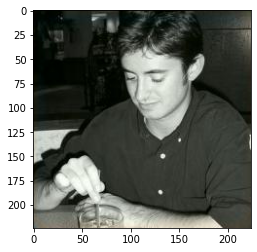

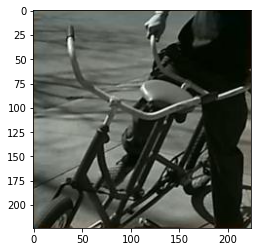

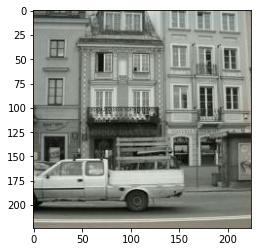

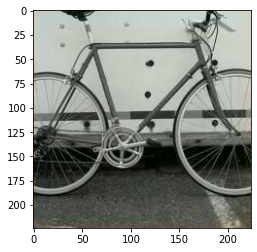

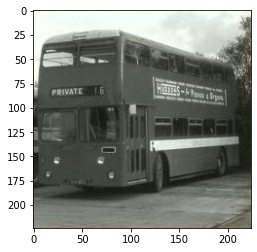

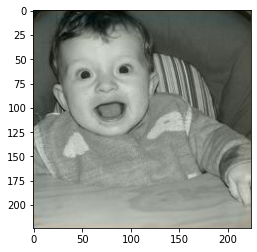

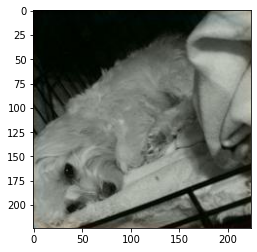

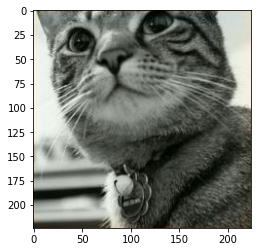

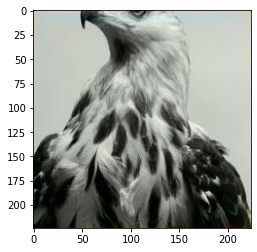

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Show results
imagesList = [1001, 1033, 1056, 1257, 1075, 1088, 1267, 115, 1225] #based on batch size of 32
for i in imagesList:
    image = mpimg.imread('/content/VOCdevkitOutputs/color/img-{}-epoch-19.jpg'.format(i))
    plt.figure()
    plt.imshow(image)